# Evaluate

In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
os.chdir('..')
sys.path.insert(1, os.path.join(sys.path[0], '..'))

from sslsv.utils.helpers import load_config
from sslsv.utils.evaluate import score_trials
from sslsv.utils.evaluate import compute_eer
from sslsv.utils.evaluate import compute_error_rates
from sslsv.utils.evaluate import compute_min_dcf

In [2]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from sklearn.manifold import TSNE

## Load embeddings *(on VoxCeleb1 test)*

In [5]:
MODEL_CONFIG_PATH = './configs/vicreg_b256.yml'

In [6]:
config, checkpoint_dir = load_config(MODEL_CONFIG_PATH)

with open(checkpoint_dir + '/embeddings.pkl', 'rb') as f:
    embeddings = pickle.load(f)

sslsv.configs.Config(
    training=sslsv.configs.TrainingConfig(batch_size=256),
    dataset=sslsv.configs.DatasetConfig(
        wav_augment=sslsv.configs.WavAugmentConfig(enable=True),
        train='./data/voxceleb1_train_list'
    ),
    _model=sslsv.model.ModelConfig.ModelConfig(
        infonce_weight=0.0,
        vicreg_weight=1.0
    ),
    name='vicreg_b256'
)


## EER and minDCF

In [7]:
scores, labels = score_trials(config.data.trials, embeddings)

eer = compute_eer(scores, labels)

fnrs, fprs = compute_error_rates(scores, labels)
min_dcf_001 = compute_min_dcf(fnrs, fprs, p_target=0.01)

print('EER (%):', eer)
print('minDCF (p=0.01):', min_dcf_001)

EER (%): 46.875
minDCF (p=0.01): 0.96875


## DET curve

In [24]:
# FIXME: nicer plot + EER

In [8]:
def det_curve(fps, fns):
    axis_min = min(fps[0], fns[-1])
    
    fig, ax = plt.subplots()
    plt.plot(fps, fns, label='Our method')
    plt.yscale('log')
    plt.xscale('log')
    ticks_to_use = [0.1, 0.2, 0.5, 1, 2, 5, 10, 20, 30, 40, 50]
    ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax.set_xticks(ticks_to_use)
    ax.set_yticks(ticks_to_use)
    plt.axis([0.01, 50, 0.01, 50])
    
    plt.xlabel('False Positive Rate (%)')
    plt.ylabel('False Negative Rate (%)')
    plt.title('DET curve')
    plt.legend()
    plt.grid(True)
    
    plt.show()

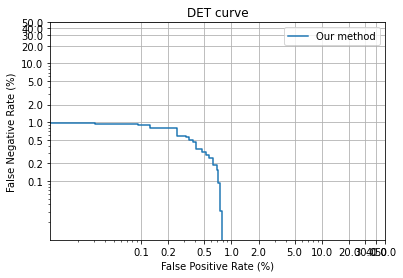

In [9]:
det_curve(fprs, fnrs)

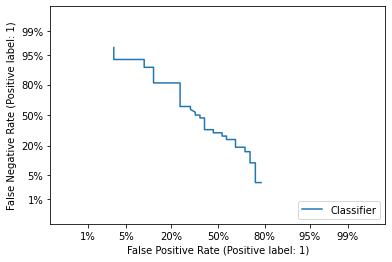

In [10]:
from sklearn.metrics import DetCurveDisplay

DetCurveDisplay.from_predictions(labels, scores)
plt.show()

## t-SNE

In [37]:
def filter_embeddings(embeddings, nb_speakers, nb_samples):
    # Determine list of speakers id
    speakers_id = [key[:-4].split('/')[0] for key in embeddings.keys()]
    speakers_id = [
        s
        for s in list(set(speakers_id))
        if speakers_id.count(s) >= nb_samples
    ]
    speakers_id = speakers_id[:nb_speakers]
    
    Z, y = [], []
    for speaker_id in speakers_id:
        i = 0
        for key in embeddings.keys():
            if i < nb_samples and speaker_id == key[:-4].split('/')[0]:
                Z.append(embeddings[key])
                y.append(speaker_id)
                i += 1
    
    return np.array(Z), y

def t_sne(embeddings, nb_speakers=10, nb_samples=150):
    Z, y = filter_embeddings(embeddings, nb_speakers, nb_samples)

    Z_2d = TSNE(n_components=2, init='random').fit_transform(Z)

    df = pd.DataFrame(Z)
    df['Speaker'] = y
    df['t-SNE_1'] = Z_2d[:, 0]
    df['t-SNE_2'] = Z_2d[:, 1]

    plt.figure(figsize=(16, 10))
    sns.scatterplot(
        x='t-SNE_1',
        y='t-SNE_2',
        hue='Speaker',
        palette=sns.color_palette('hls', len(np.unique(y))),
        data=df,
        legend='full',
        alpha=0.5
    )
    plt.show()

/home/theo/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


<Figure size 1600x1000 with 0 Axes>

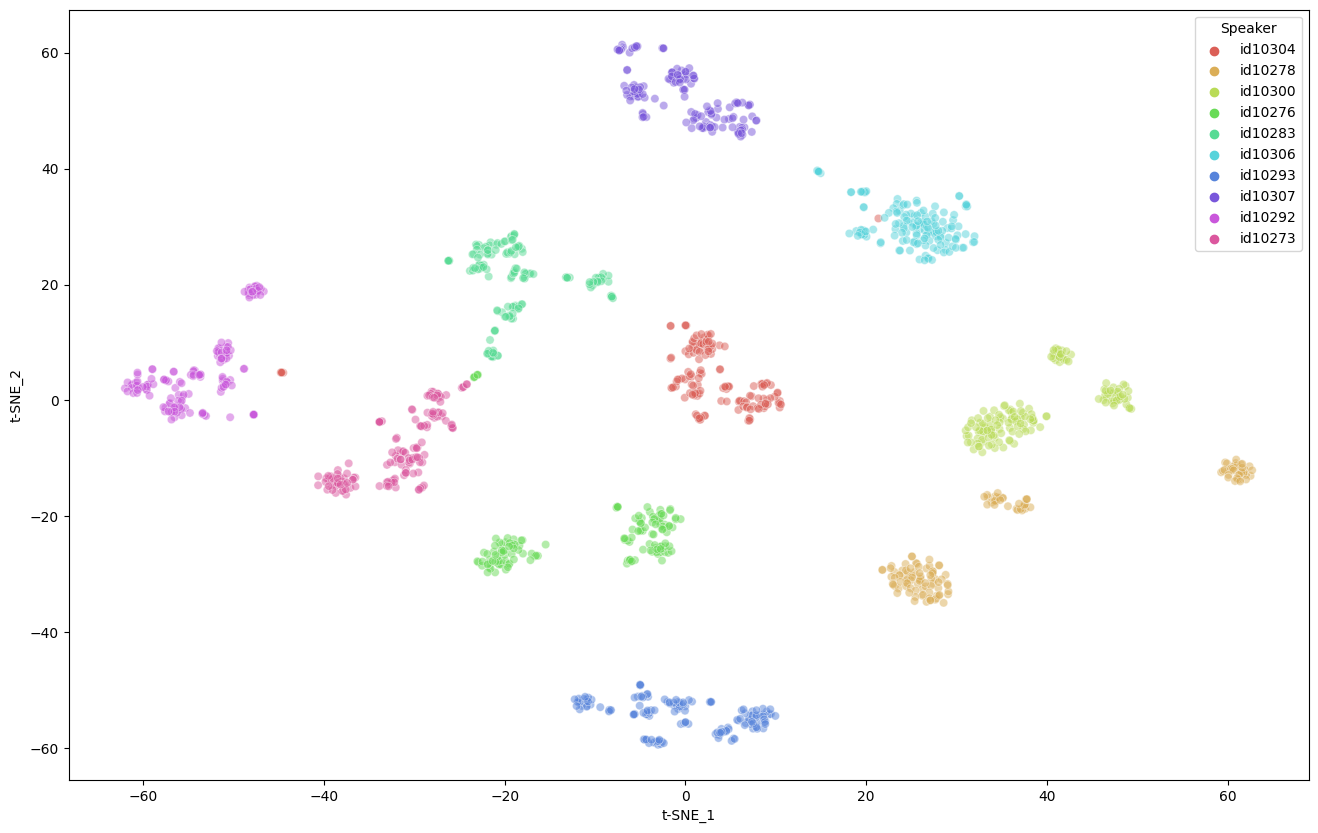

In [70]:
t_sne(embeddings)